In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.activations import selu
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import RootMeanSquaredError,MeanAbsolutePercentageError
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import LogCosh,MeanSquaredError,MeanAbsoluteError,MeanSquaredLogarithmicError
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
import json
class MetricsCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_root_mean_squared_error', mode='min'):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.best = None
        self.mode = mode
        if self.mode == 'min':
            self.compare = lambda a, b: a < b
            self.best = float('inf')
        else:
            self.compare = lambda a, b: a > b
            self.best = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        if self.compare(current, self.best):
            self.best = current
            # Сохраняем все текущие метрики эпохи в JSON
            with open(self.filepath, 'w', encoding='utf-8') as f:
                json.dump({key: float(value) for key, value in logs.items()}, f, ensure_ascii=False, indent=4)
            print(f"\nМетрики для лучшей модели сохранены в {self.filepath} на эпохе {epoch+1}")


In [4]:
def plot_history_errors(history, train_key=None, val_key=None, title='Training / validation error'):
    if history is None:
        raise ValueError("history == None: нет истории обучения, график построить нельзя")

    keys = list(history.history.keys())
    print("history keys:", keys)

    # выбор ключей для train
    if train_key is None:
        if 'root_mean_squared_error' in keys:
            train_key = 'root_mean_squared_error'
        elif 'loss' in keys:
            train_key = 'loss'
        else:
            raise ValueError("Не найден ключ для train ошибки в history.history")

    # выбор ключей для val
    if val_key is None:
        if 'val_root_mean_squared_error' in keys:
            val_key = 'val_root_mean_squared_error'
        elif 'val_loss' in keys:
            val_key = 'val_loss'
        else:
            raise ValueError("Не найден ключ для val ошибки в history.history")

    train_err = history.history[train_key]
    val_err   = history.history[val_key]

    # --- отдельный график train ---
    plt.figure(figsize=(8, 4))
    plt.plot(train_err, color='black')
    plt.xlabel('epoch')
    plt.ylabel('error')
    plt.title(f'{title} - train')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- отдельный график test/val ---
    plt.figure(figsize=(8, 4))
    plt.plot(val_err, color='gray')
    plt.xlabel('epoch')
    plt.ylabel('error')
    plt.title(f'{title} - test')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [24]:
# загружаем те же данные, что используются в LSTM модели
print("загрузка данных...")
data = pd.read_csv('bitcoin_2017_to_2023.csv')

print(f"Колонки в данных: {list(data.columns)}")  # Проверим колонки

# преобразуем timestamp в datetime, но НЕ устанавливаем как индекс
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Сортируем по дате по возрастанию (2017 -> 2023)
data = data.sort_values('timestamp').reset_index(drop=True)

print(f"период данных: {data['timestamp'].min()} до {data['timestamp'].max()}")
print(f"частота данных: {pd.infer_freq(data['timestamp'][:10])}")


загрузка данных...
Колонки в данных: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
период данных: 2017-08-17 04:00:00 до 2023-08-01 13:19:00
частота данных: min


In [25]:
from sklearn.preprocessing import StandardScaler

features = ['timestamp', 'open', 'high', 'close', 'volume',
            'quote_asset_volume', 'number_of_trades',
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp'] = data['timestamp'].astype('int64')  # числовое представление даты

X = data[features]
y = data['low']

train_size = 160000
X_train = X.iloc[:train_size].copy()
X_test  = X.iloc[train_size:train_size + 40000].copy()
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:train_size + 40000]

features_num = ['timestamp', 'open', 'high', 'close', 'volume',
                'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

X_train_num = X_train[features_num].values
X_test_num  = X_test[features_num].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled  = scaler.transform(X_test_num)

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0],
                                      X_train_scaled.shape[1],
                                      1).astype('float32')
X_test_lstm  = X_test_scaled.reshape(X_test_scaled.shape[0],
                                     X_test_scaled.shape[1],
                                     1).astype('float32')

print("X_train_lstm shape:", X_train_lstm.shape)  # (160000, 9, 1)
print("X_test_lstm shape:", X_test_lstm.shape)   # (40000, 9, 1)


X_train_lstm shape: (160000, 9, 1)
X_test_lstm shape: (40000, 9, 1)


In [35]:
model_path = 'best_model.keras'
metrics_path = 'best_model_metrics.json'

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
    print(model.summary())
    print("Оценка на тесте:")
else:
    print("Обучаем новую модель с LSTM...")

    model = Sequential([
        LSTM(16, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.17),
        LSTM(16, return_sequences=False, activation='relu'),
        Dropout(0.17),
        Dense(1)
    ])

    model.compile(
        optimizer=Nadam(learning_rate=0.001),
        loss=LogCosh(),
        metrics=[
            RootMeanSquaredError(),
            MeanAbsoluteError(name='mae'),
            MeanAbsolutePercentageError(name='mape'),
            tf.keras.metrics.R2Score(name='r2')
        ]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    metrics_checkpoint = MetricsCheckpoint(metrics_path, monitor='val_root_mean_squared_error', mode='min')

    history = model.fit(
        X_train_lstm, y_train,
        epochs=488,
        batch_size=216,
        validation_data=(X_test_lstm, y_test),
        callbacks=[checkpoint, early_stopping, metrics_checkpoint]
    )

    print("Обучение завершено. Лучшая модель и метрики сохранены.")

Загружаем существующую обученную модель...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 9, 16)          │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 9, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,846 (38.46 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,565 (25.65 KB)

None
Оценка на тесте:


slice_df shape: (40000, 10)
Model input shape: (None, 9, 1)
slice_X_lstm shape: (40000, 9, 1)


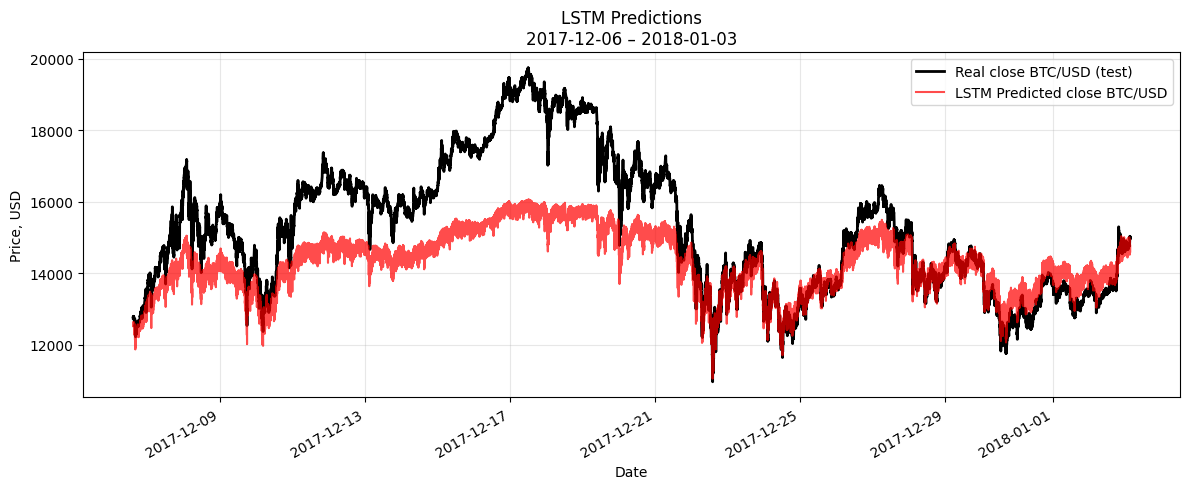

Тестовая выборка: 2017-12-06 14:27:00 – 2018-01-03 02:59:00
y_pred range: 11048.39 - 16075.16
y_real range: 10961.00 - 19752.11


In [36]:
slice_df = data.iloc[train_size:train_size + 40000].copy()
print("slice_df shape:", slice_df.shape)

# ✅ ТЕ ЖЕ 9 признаков, что использовались при обучении (включая timestamp)
features_num = ['timestamp', 'open', 'high', 'close', 'volume',
                'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

# Извлекаем 9 признаков (включая timestamp)
slice_X_num = slice_df[features_num].astype('float32').values

slice_X_scaled = scaler.transform(slice_X_num)

# Формируем (40000, 9, 1) - точно как модель ожидает
slice_X_lstm = slice_X_scaled.reshape((slice_X_scaled.shape[0],
                                       slice_X_scaled.shape[1],
                                       1)).astype('float32')

print(f"Model input shape: {model.input_shape}")      # (None, 9, 1)
print(f"slice_X_lstm shape: {slice_X_lstm.shape}")    # (40000, 9, 1)

# ✅ Теперь предсказания заработают
y_pred = model.predict(slice_X_lstm, batch_size=256, verbose=0).flatten()

# Даты для визуализации (без изменения длины)
dates = pd.to_datetime(slice_df['timestamp'])
y_real = y_test.values  # или y_test.to_numpy() если это Series

start_date = dates.min()
end_date = dates.max()

# Остальной код визуализации остается тем же
import matplotlib.dates as mdates
plt.figure(figsize=(12, 5))
plt.plot(dates, y_real, label='Real close BTC/USD (test)', color='black', linewidth=2)
plt.plot(dates, y_pred, label='LSTM Predicted close BTC/USD', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price, USD')
plt.title(f'LSTM Predictions\n{start_date.date()} – {end_date.date()}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Тестовая выборка: {start_date} – {end_date}")
print(f"y_pred range: {y_pred.min():.2f} - {y_pred.max():.2f}")
print(f"y_real range: {y_real.min():.2f} - {y_real.max():.2f}")


Обучаем новую модель...
Epoch 1/310


C:\Users\Егор\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1598/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1411.2264 - mae: 1411.9195 - mape: 24.5331 - r2: -0.4890 - root_mean_squared_error: 2218.8192
Epoch 1: val_root_mean_squared_error improved from None to 1521.34180, saving model to best_model_2.keras

Метрики для лучшей модели сохранены в best_model_2_metrics.json на эпохе 1
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 736.0281 - mae: 736.7211 - mape: 12.7613 - r2: 0.5628 - root_mean_squared_error: 1346.9641 - val_loss: 1201.7133 - val_mae: 1202.4066 - val_mape: 7.3636 - val_r2: 0.3296 - val_root_mean_squared_error: 1521.3418
Epoch 2/310
1593/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 474.8560 - mae: 475.5485 - mape: 8.1887 - r2: 0.9017 - root_mean_squared_error: 637.5623
Epoch 2: val_root_mean_squared_error improved from 1521.34180 to 1347.61719, saving model to best_model_2.keras

Метрики для лучшей модели сохранены в best_model_2_metrics.json на эпохе 2
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 468.3955 - mae: 46

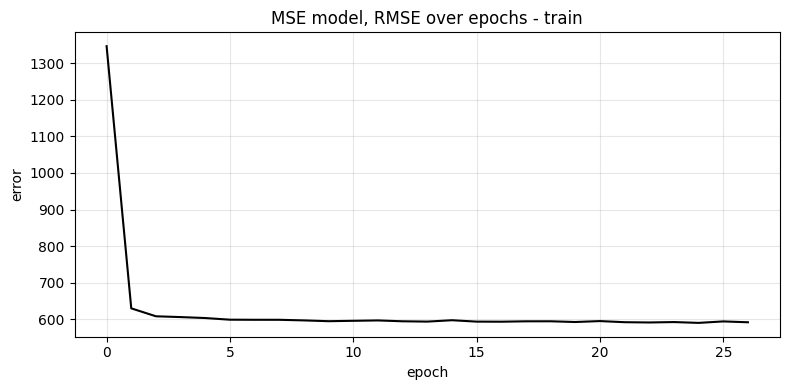

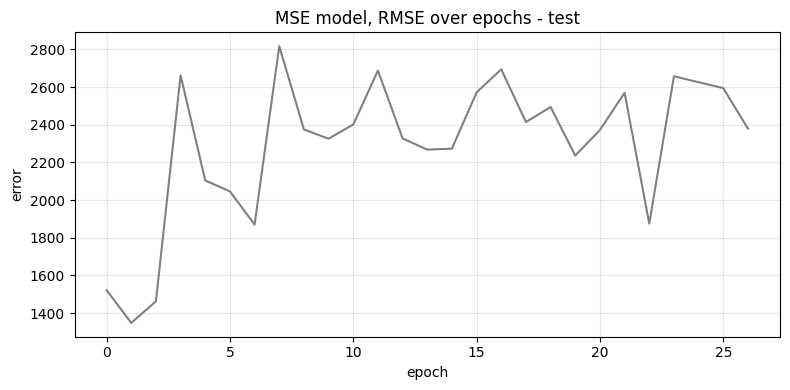

In [37]:
model_path = 'best_model_2.keras'
metrics_path = 'best_model_2_metrics.json'
history = None
if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
    print(model.summary())         
    print("Оценка на тесте:")
else:
    print("Обучаем новую модель...")
    model = Sequential([
        LSTM(26, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.19),
        LSTM(26, return_sequences=False, activation='linear'),
        Dropout(0.19),
        Dense(1)
    ])

    model.compile(
        optimizer=Nadam(),
        loss=LogCosh(),
        metrics=[
            RootMeanSquaredError(),
            MeanAbsoluteError(name='mae'),
            MeanAbsolutePercentageError(name='mape'),
            tf.keras.metrics.R2Score(name='r2')
        ]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    metrics_checkpoint = MetricsCheckpoint(
        metrics_path,
        monitor='val_root_mean_squared_error',
        mode='min'
    )

    history = model.fit(
        X_train_lstm, y_train,
        epochs=310,
        batch_size=100,
        validation_data=(X_test_lstm, y_test),
        callbacks=[checkpoint, early_stopping, metrics_checkpoint]
    )

    print("Обучение завершено. Лучшая модель и метрики сохранены.")

if history is not None:
    plot_history_errors(history, title='MSE model, RMSE over epochs')
else:
    print("Модель загружена из файла: history нет, график по эпохам построить нельзя.")

slice_df shape: (40000, 10)
Model input shape: (None, 9, 1)
slice_X_lstm shape: (40000, 9, 1)


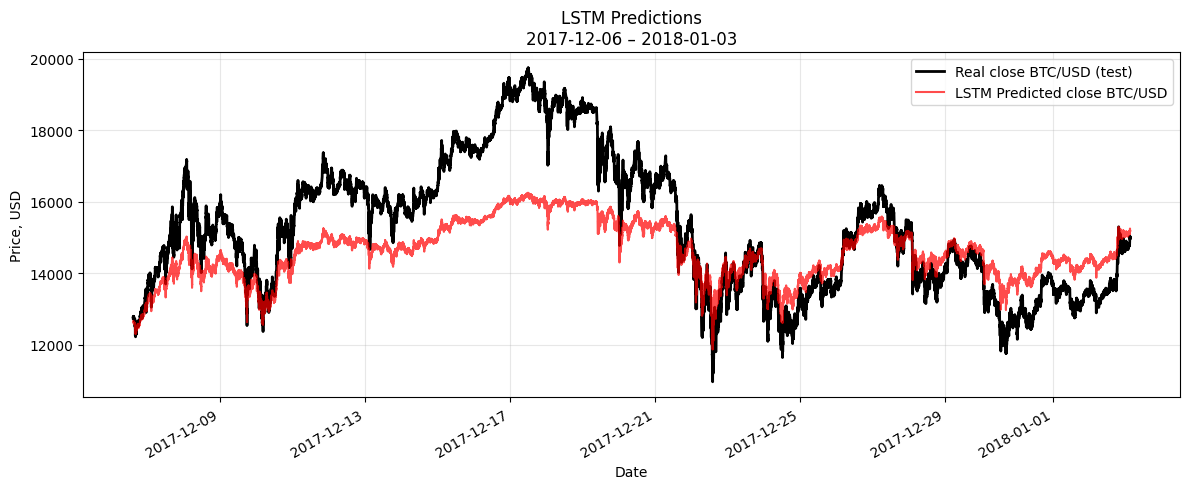

Тестовая выборка: 2017-12-06 14:27:00 – 2018-01-03 02:59:00
y_pred range: 11864.66 - 16255.06
y_real range: 10961.00 - 19752.11


In [38]:
slice_df = data.iloc[train_size:train_size + 40000].copy()
print("slice_df shape:", slice_df.shape)

# ✅ ТЕ ЖЕ 9 признаков, что использовались при обучении (включая timestamp)
features_num = ['timestamp', 'open', 'high', 'close', 'volume',
                'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

# Извлекаем 9 признаков (включая timestamp)
slice_X_num = slice_df[features_num].astype('float32').values

slice_X_scaled = scaler.transform(slice_X_num)

# Формируем (40000, 9, 1) - точно как модель ожидает
slice_X_lstm = slice_X_scaled.reshape((slice_X_scaled.shape[0],
                                       slice_X_scaled.shape[1],
                                       1)).astype('float32')

print(f"Model input shape: {model.input_shape}")      # (None, 9, 1)
print(f"slice_X_lstm shape: {slice_X_lstm.shape}")    # (40000, 9, 1)

# ✅ Теперь предсказания заработают
y_pred = model.predict(slice_X_lstm, batch_size=256, verbose=0).flatten()

# Даты для визуализации (без изменения длины)
dates = pd.to_datetime(slice_df['timestamp'])
y_real = y_test.values  # или y_test.to_numpy() если это Series

start_date = dates.min()
end_date = dates.max()

# Остальной код визуализации остается тем же
import matplotlib.dates as mdates
plt.figure(figsize=(12, 5))
plt.plot(dates, y_real, label='Real close BTC/USD (test)', color='black', linewidth=2)
plt.plot(dates, y_pred, label='LSTM Predicted close BTC/USD', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price, USD')
plt.title(f'LSTM Predictions\n{start_date.date()} – {end_date.date()}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Тестовая выборка: {start_date} – {end_date}")
print(f"y_pred range: {y_pred.min():.2f} - {y_pred.max():.2f}")
print(f"y_real range: {y_real.min():.2f} - {y_real.max():.2f}")


Обучаем новую модель...
Epoch 1/381


C:\Users\Егор\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1994/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9916306.4733 - mae: 1867.3316 - mape: 32.1596 - r2: -1.4138 - root_mean_squared_error: 2883.4954
Epoch 1: val_root_mean_squared_error improved from None to 2230.51440, saving model to best_model_3.keras

Метрики для лучшей модели сохранены в best_model_3_metrics.json на эпохе 1
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 2986202.5000 - mae: 823.7376 - mape: 14.1724 - r2: 0.2803 - root_mean_squared_error: 1728.0632 - val_loss: 4975194.5000 - val_mae: 1745.0927 - val_mape: 10.6072 - val_r2: -0.4410 - val_root_mean_squared_error: 2230.5144
Epoch 2/381
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 279242.3016 - mae: 361.1386 - mape: 6.1649 - r2: 0.9330 - root_mean_squared_error: 528.3046
Epoch 2: val_root_mean_squared_error improved from 2230.51440 to 1737.57141, saving model to best_model_3.keras

Метрики для лучшей модели сохранены в best_model_3_metrics.json на эпохе 2
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 264

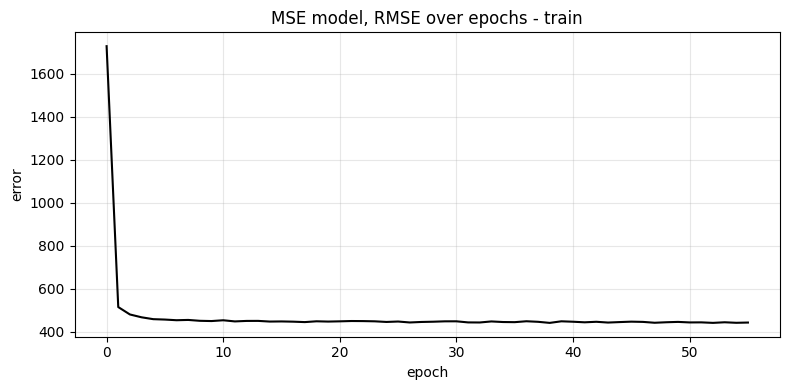

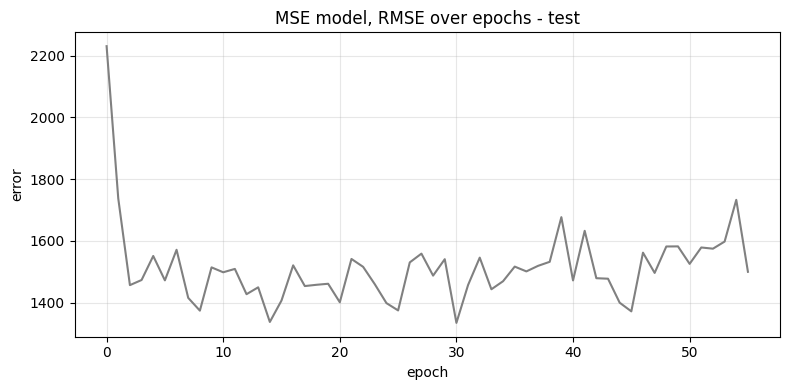

In [39]:
model_path = 'best_model_3.keras'
metrics_path = 'best_model_3_metrics.json'
history = None
if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
    print(model.summary())              # структура модели
    print("Оценка на тесте:")
else:
    print("Обучаем новую модель...")
    model = Sequential([
        LSTM(6, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.03),
        LSTM(6, return_sequences=False, activation='linear'),
        Dropout(0.03),
        Dense(1)
    ])

    model.compile(
        optimizer=Nadam(),
        loss=MeanSquaredError(),
        metrics=[
            RootMeanSquaredError(),
            MeanAbsoluteError(name='mae'),
            MeanAbsolutePercentageError(name='mape'),
            tf.keras.metrics.R2Score(name='r2')
        ]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    metrics_checkpoint = MetricsCheckpoint(
        metrics_path,
        monitor='val_root_mean_squared_error',
        mode='min'
    )

    history = model.fit(
        X_train_lstm, y_train,
        epochs=381,
        batch_size=80,
        validation_data=(X_test_lstm, y_test),
        callbacks=[checkpoint, early_stopping, metrics_checkpoint]
    )

    print("Обучение завершено. Лучшая модель и метрики сохранены.")

if history is not None:
    plot_history_errors(history, title='MSE model, RMSE over epochs')
else:
    print("Модель загружена из файла: history нет, график по эпохам построить нельзя.")


slice_df shape: (40000, 10)
Model input shape: (None, 9, 1)
slice_X_lstm shape: (40000, 9, 1)


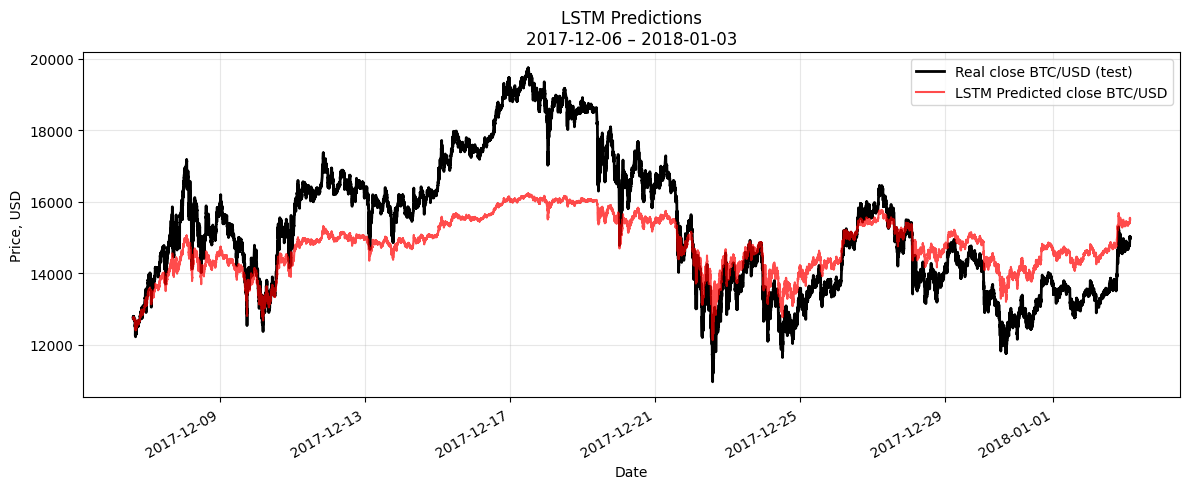

Тестовая выборка: 2017-12-06 14:27:00 – 2018-01-03 02:59:00
y_pred range: 12127.08 - 16235.86
y_real range: 10961.00 - 19752.11


In [40]:
slice_df = data.iloc[train_size:train_size + 40000].copy()
print("slice_df shape:", slice_df.shape)

# ✅ ТЕ ЖЕ 9 признаков, что использовались при обучении (включая timestamp)
features_num = ['timestamp', 'open', 'high', 'close', 'volume',
                'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

# Извлекаем 9 признаков (включая timestamp)
slice_X_num = slice_df[features_num].astype('float32').values

slice_X_scaled = scaler.transform(slice_X_num)

# Формируем (40000, 9, 1) - точно как модель ожидает
slice_X_lstm = slice_X_scaled.reshape((slice_X_scaled.shape[0],
                                       slice_X_scaled.shape[1],
                                       1)).astype('float32')

print(f"Model input shape: {model.input_shape}")      # (None, 9, 1)
print(f"slice_X_lstm shape: {slice_X_lstm.shape}")    # (40000, 9, 1)

# ✅ Теперь предсказания заработают
y_pred = model.predict(slice_X_lstm, batch_size=256, verbose=0).flatten()

# Даты для визуализации (без изменения длины)
dates = pd.to_datetime(slice_df['timestamp'])
y_real = y_test.values  # или y_test.to_numpy() если это Series

start_date = dates.min()
end_date = dates.max()

# Остальной код визуализации остается тем же
import matplotlib.dates as mdates
plt.figure(figsize=(12, 5))
plt.plot(dates, y_real, label='Real close BTC/USD (test)', color='black', linewidth=2)
plt.plot(dates, y_pred, label='LSTM Predicted close BTC/USD', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price, USD')
plt.title(f'LSTM Predictions\n{start_date.date()} – {end_date.date()}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Тестовая выборка: {start_date} – {end_date}")
print(f"y_pred range: {y_pred.min():.2f} - {y_pred.max():.2f}")
print(f"y_real range: {y_real.min():.2f} - {y_real.max():.2f}")


Обучаем новую модель...
Epoch 1/373


C:\Users\Егор\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7317466.1848 - mae: 1620.7426 - mape: 29.5457 - r2: -0.7853 - root_mean_squared_error: 2438.0218
Epoch 1: val_root_mean_squared_error improved from None to 2000.87817, saving model to best_model_4.keras

Метрики для лучшей модели сохранены в best_model_4_metrics.json на эпохе 1
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 2131766.7500 - mae: 775.0624 - mape: 14.0262 - r2: 0.4862 - root_mean_squared_error: 1460.0571 - val_loss: 4003513.5000 - val_mae: 1569.0532 - val_mape: 9.5295 - val_r2: -0.1596 - val_root_mean_squared_error: 2000.8782
Epoch 2/373
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 327863.4029 - mae: 428.8202 - mape: 7.4989 - r2: 0.9211 - root_mean_squared_error: 572.5447
Epoch 2: val_root_mean_squared_error improved from 2000.87817 to 1288.56519, saving model to best_model_4.keras

Метрики для лучшей модели сохранены в best_model_4_metrics.json на эпохе 2
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 3169

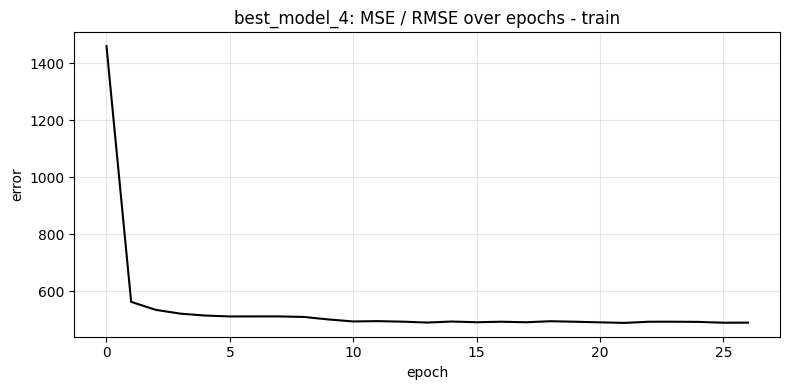

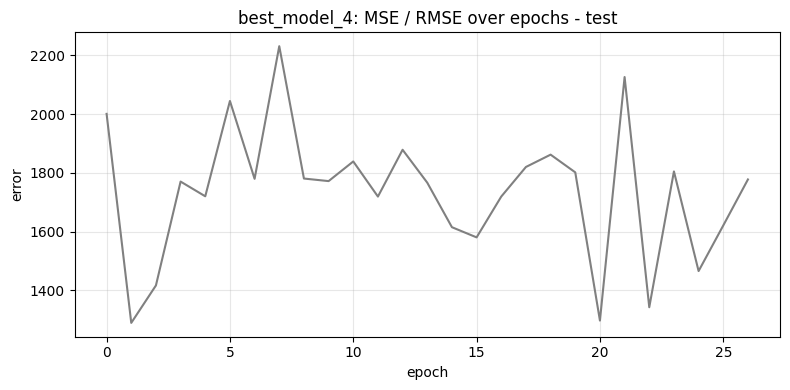

In [41]:
model_path = 'best_model_4.keras'
metrics_path = 'best_model_4_metrics.json'
history = None
if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
    print(model.summary())         
    print("Оценка на тесте:")
    eval_res = model.evaluate(X_test, y_test, verbose=0)
    print("loss =", eval_res[0])
    if len(eval_res) > 1:
        print("RMSE =", eval_res[1])
else:
    print("Обучаем новую модель...")
    model = Sequential([
        LSTM(14, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.08),
        LSTM(14, return_sequences=False, activation='linear'),
        Dropout(0.08),
        Dense(1)
    ])

    model.compile(
        optimizer=Nadam(),
        loss=MeanSquaredError(),
        metrics=[
            RootMeanSquaredError(),
            MeanAbsoluteError(name='mae'),
            MeanAbsolutePercentageError(name='mape'),
            tf.keras.metrics.R2Score(name='r2')
        ]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    metrics_checkpoint = MetricsCheckpoint(
        metrics_path,
        monitor='val_root_mean_squared_error',
        mode='min'
    )

    history = model.fit(
        X_train_lstm, y_train,
        epochs=373,
        batch_size=80,
        validation_data=(X_test_lstm, y_test),
        callbacks=[checkpoint, early_stopping, metrics_checkpoint]
    )

    print("Обучение завершено. Лучшая модель и метрики сохранены.")

if history is not None:
    plot_history_errors(history, title='best_model_4: MSE / RMSE over epochs')
else:
    print("Модель загружена из файла: history отсутствует, "
          "поэтому график обучения по эпохам в этом запуске построить нельзя.")


slice_df shape: (40000, 10)
Model input shape: (None, 9, 1)
slice_X_lstm shape: (40000, 9, 1)


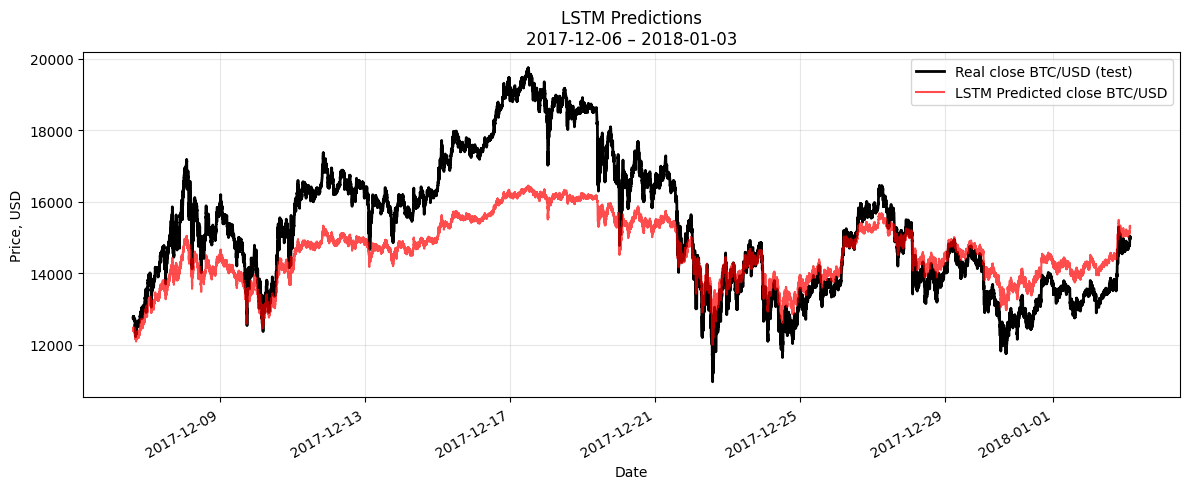

Тестовая выборка: 2017-12-06 14:27:00 – 2018-01-03 02:59:00
y_pred range: 11999.32 - 16453.15
y_real range: 10961.00 - 19752.11


In [42]:
slice_df = data.iloc[train_size:train_size + 40000].copy()
print("slice_df shape:", slice_df.shape)

# ✅ ТЕ ЖЕ 9 признаков, что использовались при обучении (включая timestamp)
features_num = ['timestamp', 'open', 'high', 'close', 'volume',
                'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

# Извлекаем 9 признаков (включая timestamp)
slice_X_num = slice_df[features_num].astype('float32').values

slice_X_scaled = scaler.transform(slice_X_num)

# Формируем (40000, 9, 1) - точно как модель ожидает
slice_X_lstm = slice_X_scaled.reshape((slice_X_scaled.shape[0],
                                       slice_X_scaled.shape[1],
                                       1)).astype('float32')

print(f"Model input shape: {model.input_shape}")      # (None, 9, 1)
print(f"slice_X_lstm shape: {slice_X_lstm.shape}")    # (40000, 9, 1)

# ✅ Теперь предсказания заработают
y_pred = model.predict(slice_X_lstm, batch_size=256, verbose=0).flatten()

# Даты для визуализации (без изменения длины)
dates = pd.to_datetime(slice_df['timestamp'])
y_real = y_test.values  # или y_test.to_numpy() если это Series

start_date = dates.min()
end_date = dates.max()

# Остальной код визуализации остается тем же
import matplotlib.dates as mdates
plt.figure(figsize=(12, 5))
plt.plot(dates, y_real, label='Real close BTC/USD (test)', color='black', linewidth=2)
plt.plot(dates, y_pred, label='LSTM Predicted close BTC/USD', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price, USD')
plt.title(f'LSTM Predictions\n{start_date.date()} – {end_date.date()}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Тестовая выборка: {start_date} – {end_date}")
print(f"y_pred range: {y_pred.min():.2f} - {y_pred.max():.2f}")
print(f"y_real range: {y_real.min():.2f} - {y_real.max():.2f}")


In [47]:
model_path = 'best_model_5.keras'
metrics_path = 'best_model_5_metrics.json'
history = None

if os.path.exists(model_path):
    print("Загружаем существующую обученную модель...")
    model = load_model(model_path)
else:
    print("Обучаем новую модель...")
    model = Sequential([
        LSTM(5, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.11),
        LSTM(5, return_sequences=False, activation='tanh'),
        Dropout(0.11),
        Dense(1)
    ])

    model.compile(
        optimizer='Adadelta',
        loss=MeanAbsoluteError(),
        metrics=[
            RootMeanSquaredError(),
            MeanAbsoluteError(name='mae'),
            MeanAbsolutePercentageError(name='mape'),
            tf.keras.metrics.R2Score(name='r2')
        ]
    )

    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_root_mean_squared_error',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=25,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )

    metrics_checkpoint = MetricsCheckpoint(
        metrics_path,
        monitor='val_root_mean_squared_error',
        mode='min'
    )

    history = model.fit(
        X_train_lstm, y_train,
        epochs=494,
        batch_size=110,
        validation_data=(X_test_lstm, y_test),
        callbacks=[checkpoint, early_stopping, metrics_checkpoint]
    )

    print("Обучение завершено. Лучшая модель и метрики сохранены.")

if history is not None:
    plot_history_errors(history, title='best_model_5: MAE / RMSE over epochs')
else:
    print("Модель загружена из файла: history отсутствует, "
          "поэтому график обучения по эпохам в этом запуске построить нельзя.")


Загружаем существующую обученную модель...
Модель загружена из файла: history отсутствует, поэтому график обучения по эпохам в этом запуске построить нельзя.


slice_df shape: (40000, 10)
Model input shape: (None, 9, 1)
slice_X_lstm shape: (40000, 9, 1)


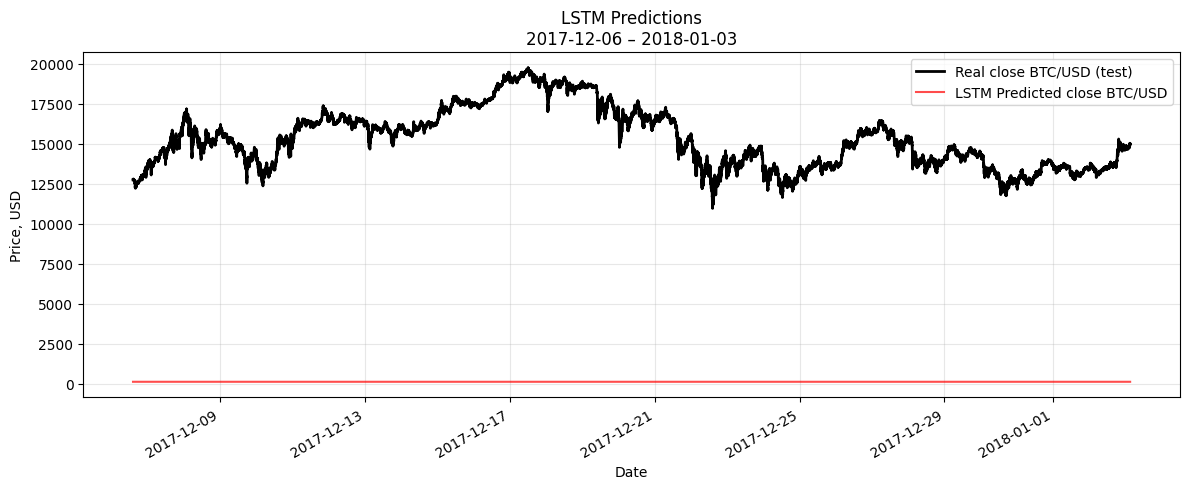

Тестовая выборка: 2017-12-06 14:27:00 – 2018-01-03 02:59:00
y_pred range: 115.23 - 115.24
y_real range: 10961.00 - 19752.11


In [48]:
slice_df = data.iloc[train_size:train_size + 40000].copy()
print("slice_df shape:", slice_df.shape)

# ✅ ТЕ ЖЕ 9 признаков, что использовались при обучении (включая timestamp)
features_num = ['timestamp', 'open', 'high', 'close', 'volume',
                'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

# Извлекаем 9 признаков (включая timestamp)
slice_X_num = slice_df[features_num].astype('float32').values

slice_X_scaled = scaler.transform(slice_X_num)

# Формируем (40000, 9, 1) - точно как модель ожидает
slice_X_lstm = slice_X_scaled.reshape((slice_X_scaled.shape[0],
                                       slice_X_scaled.shape[1],
                                       1)).astype('float32')

print(f"Model input shape: {model.input_shape}")      # (None, 9, 1)
print(f"slice_X_lstm shape: {slice_X_lstm.shape}")    # (40000, 9, 1)

# ✅ Теперь предсказания заработают
y_pred = model.predict(slice_X_lstm, batch_size=256, verbose=0).flatten()

# Даты для визуализации (без изменения длины)
dates = pd.to_datetime(slice_df['timestamp'])
y_real = y_test.values  # или y_test.to_numpy() если это Series

start_date = dates.min()
end_date = dates.max()

# Остальной код визуализации остается тем же
import matplotlib.dates as mdates
plt.figure(figsize=(12, 5))
plt.plot(dates, y_real, label='Real close BTC/USD (test)', color='black', linewidth=2)
plt.plot(dates, y_pred, label='LSTM Predicted close BTC/USD', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price, USD')
plt.title(f'LSTM Predictions\n{start_date.date()} – {end_date.date()}')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Тестовая выборка: {start_date} – {end_date}")
print(f"y_pred range: {y_pred.min():.2f} - {y_pred.max():.2f}")
print(f"y_real range: {y_real.min():.2f} - {y_real.max():.2f}")


In [ ]:
print(data['timestamp'].min(), data['timestamp'].max())

2023-03-15 14:40:00 2023-08-01 13:19:00
